In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule, LightningModule
from pytorch_lightning import Trainer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

In [2]:
from sklearn.metrics import accuracy_score

In [3]:
writer = SummaryWriter()


In [7]:
class MHClassifier(nn.Module):
    def __init__(self, peptide_input, protein_input, peptide_hideen_layers, protein_hideen_layers,peptide_protein_hideen_layers, output_size):
        super(MHClassifier, self).__init__()

        self.device = 'cpu' 

        ## Peptide encoder 
        layer_modules = []
        bias = False
        input_p = peptide_input
        for layer in peptide_hideen_layers:
            layer_modules.append(
                nn.Sequential(
                    nn.Linear(input_p,out_features = layer,bias=bias),
                    nn.BatchNorm1d(layer),
                    nn.ReLU(),
                    #nn.Dropout(p=0.3)
                    )
                )
            input_p = layer

        self.layers_peptide = nn.Sequential(*layer_modules)

        ## Protein encoder 
        ## Protein encoder 
        layer_modules = []
        bias = False
        input_pro = protein_input
        for layer in protein_hideen_layers:
            layer_modules.append(
                nn.Sequential(
                    nn.Linear(input_pro,out_features = layer,bias=bias),
                    #nn.BatchNorm1d(layer),
                    #nn.ReLU(),
                    #nn.Dropout(p=drop_rate)
                    )
                )
            input_pro = layer
            

        self.layers_protein = nn.Sequential(*layer_modules)
        
        ## Protein-Peptide Concatenation layer
        layer_modules = []
        bias = False
        self.peptide_protein_concat = nn.Linear(input_p + input_pro, input_p + input_pro)
        
        ## Protein-Peptide combined network 
        layer_modules = []
        bias = False
        input_combined = input_p + input_pro
        for layer in peptide_protein_hideen_layers:
            layer_modules.append(
                nn.Sequential(
                    nn.Linear(input_combined,out_features = layer,bias=bias),
                    nn.BatchNorm1d(layer),
                    #nn.ReLU(),
                    #nn.Dropout(p=drop_rate)
                    )
                )
            input_combined = layer
        #layer_modules.append(nn.sigmoid())

        self.Combined_Peptide_protein_layer = nn.Sequential(*layer_modules)

        
    def forward(self, peptide:Tensor, protein:Tensor): 
        pep = self.layers_peptide(peptide)
        pro = self.layers_protein(protein)
        conct_pep_pro = torch.cat((pep, pro), dim=1)
        combined_pep_pro = self.peptide_protein_concat(conct_pep_pro)
        final_output = self.Combined_Peptide_protein_layer(combined_pep_pro)
        return final_output

In [8]:
class DataPlanner(LightningDataModule):
    def __init__(self, X1, X2, y, batch_size,workers):
        super().__init__()
        self.X1 = X1
        self.X2 = X2
        self.y = y
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(self.X1, self.X2, self.y, test_size=0.3, random_state=42)
        self.train_data = torch.utils.data.TensorDataset(torch.tensor(X1_train,dtype=torch.float), torch.tensor(X2_train,dtype=torch.float), torch.tensor(y_train,dtype=torch.float).unsqueeze(1))
        self.val_data = torch.utils.data.TensorDataset(torch.tensor(X1_val,dtype=torch.float), torch.tensor(X2_val,dtype=torch.float), torch.tensor(y_val,dtype=torch.float).unsqueeze(1))

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True,num_workers=self.workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size)

In [9]:

class LightningModel(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

    def forward(self, x1, x2):
        return self.model(x1, x2)

    def training_step(self, batch, batch_idx):
        x1, x2, y = batch
        outputs = self(x1, x2)
        loss = self.criterion(outputs, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x1, x2, y = batch
        outputs = self(x1, x2)
        loss = self.criterion(outputs, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)
    
    def predict(self, x1, x2):
        self.eval()
        with torch.no_grad():
            output = torch.sigmoid(self(x1, x2)
            return output    

In [10]:
# Input the data and modify for training the model
fold_train = pd.read_csv("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/data/fold_train.csv") 
fold_test = pd.read_csv("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/data/fold_test.csv") 
HLA_embeddings = pd.read_csv("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/data/HLA_embeddings.csv")

In [11]:
HLA_embeddings["protein_embed"] = [np.array(list(eval(s))) for s in HLA_embeddings["protein_embed"]]

In [12]:
# Encoding the peptide sequence using one hot encoding
def one_hot_encoding(sequence):
    # Define the mapping of amino acids to indices
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded array
    num_amino_acids = len(amino_acids)
    encoding = np.zeros((len(sequence), num_amino_acids))

    # Encode each amino acid in the sequence
    for i, aa in enumerate(sequence):
        if aa in aa_to_index:
            index = aa_to_index[aa]
            encoding[i][index] = 1
        else:
            # Handle unknown amino acids (e.g., 'X')
            encoding[i][-1] = 1

    return encoding.ravel()

In [13]:
#fold_train['peptide_input'] = fold_train['clean_peptide'].apply(one_hot_encoding)
#fold_test['peptide_input'] = fold_test['clean_peptide'].apply(one_hot_encoding)

In [14]:
train_data = fold_train.merge(HLA_embeddings,left_on="allele",right_on="allele")
test_data = fold_test.merge(HLA_embeddings,left_on="allele",right_on="allele")

In [15]:
fold_0_train = train_data[train_data["data"] == "fold_0"]


In [16]:
fold_0_train['peptide_input'] = fold_0_train['clean_peptide'].apply(one_hot_encoding)


/tmp/ipykernel_25086/4203387904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_0_train['peptide_input'] = fold_0_train['clean_peptide'].apply(one_hot_encoding)


In [17]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(fold_0_train["peptide_input"], fold_0_train["protein_embed"], fold_0_train["hit"], test_size=0.2, random_state=42,stratify = fold_0_train["hit"])


In [18]:
X1_train = np.array(X1_train.tolist())
X2_train = np.array(X2_train.tolist())
y_train = np.array(y_train.tolist())

In [19]:
# Define hidden layers and input data sizes
peptide_input = 180  # Length of peptide sequence 8 * 20 = 160 
protein_input = 1024  # Dimension of categorical variable defining protein sequence
peptide_hideen_layers = [90,18]  # Hidden layers for peptide network 
protein_hideen_layers = [512,18]  # Hidden layers for protein network 
peptide_protein_hideen_layers = [36,1] # Hidden layers size for protein-peptide concatenated network
output_size = 1  # Output size
batch_size = 1000 # batch size 
workers = 10 # number of cpu/gpu cores

# Create model instance
model = MHClassifier(peptide_input, protein_input, peptide_hideen_layers, protein_hideen_layers,peptide_protein_hideen_layers, output_size)

# Create Lightning model
lightning_model = LightningModel(model)

# Create DataModule and input the data
data_module = DataPlanner(X1_train,X2_train, y_train, batch_size,workers)

# Defining the logger object
logger = TensorBoardLogger("/home/gaurav/Gaurav/Berlin/Proposals/Test/InstaDeep/notebooks/",name="MHClassifier")

# Create Trainer
trainer = Trainer(max_epochs=30,accelerator='cpu',logger=logger)



/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853668/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and inst

In [20]:
model

MHClassifier(
  (layers_peptide): Sequential(
    (0): Sequential(
      (0): Linear(in_features=180, out_features=90, bias=False)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=18, bias=False)
      (1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layers_protein): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=False)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=18, bias=False)
    )
  )
  (peptide_protein_concat): Linear(in_features=36, out_features=36, bias=True)
  (Combined_Peptide_protein_layer): Sequential(
    (0): Sequential(
      (0): Linear(in_features=36, out_features=36, bias=False)
      (1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
  

In [21]:
# Train the model
trainer.fit(lightning_model, data_module)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | MHClassifier      | 554 K 
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.217     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/gaurav/anaconda3/envs/project/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755853668/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [22]:
X1_test = np.array(X1_test.tolist())
X2_test = np.array(X2_test.tolist())
y_test = np.array(y_test.tolist())

In [23]:
y_predict = lightning_model.predict(torch.tensor(X1_test,dtype=torch.float),torch.tensor(X2_test,dtype=torch.float))

In [24]:
y_predict = y_predict.cpu().detach().numpy()
y_predict = np.array(y_predict.ravel())

In [25]:
Prediction = pd.DataFrame({'Target':y_test, 'Predicted_probability':y_predict})

In [26]:
Prediction["Predicted"] = 0
Prediction["Predicted"][Prediction["Predicted_probability"] > 0.8] = 1

/tmp/ipykernel_25086/650287538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Prediction["Predicted"][Prediction["Predicted_probability"] > 0.8] = 1


In [27]:
accuracy_score(Prediction["Target"], Prediction["Predicted"])

0.9504307560499636

In [28]:
#AUC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_score):
    """
    Plot ROC curve and compute AUC.
    
    Parameters:
        y_true (array-like): True binary labels.
        y_score (array-like): Target scores, can either be probability estimates of the positive class or confidence values.
        
    Returns:
        auc_score: Area under the ROC curve.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return auc_score


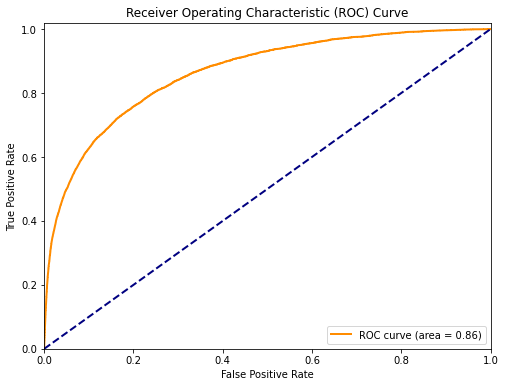

0.8633306345570765

In [29]:
plot_roc_curve(Prediction["Target"],Prediction["Predicted_probability"])


In [30]:
#checking on test data

In [34]:
# Input the data and modify for training the model
test_data['peptide_input'] = test_data['clean_peptide'].apply(one_hot_encoding)


In [36]:

pep_test = np.array(test_data["peptide_input"].tolist()) 
pro_test = np.array(test_data["protein_embed"].tolist())
target_test = np.array(test_data["hit"].tolist())

In [ ]:
target_predict = lightning_model.predict(torch.tensor(pep_test,dtype=torch.float),torch.tensor(pro_test,dtype=torch.float))

In [ ]:
target_predict = target_predict.cpu().detach().numpy()
target_predict = np.array(target_predict.ravel())

In [ ]:
Prediction_testdata = pd.DataFrame({'Target':target_test, 'Predicted_probability':target_predict})

In [ ]:
Prediction_testdata["Predicted"] = 0
Prediction_testdata["Predicted"][Prediction_testdata["Predicted_probability"] > 0.5] = 1

In [ ]:
accuracy_score(Prediction_testdata["Target"], Prediction_testdata["Predicted"])

In [2]:
def save_model(self,path):
    torch.save(self.model.state_dict(),path)


def reload_model(self,path):
    self.model.load_state_dict(torch.load(path))
    self.model.eval()